In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import tqdm

,timeStamp,ghi,dni,dhi
0,2014-01-02 08:00:00,0.0,0.0,0.0
1,2014-01-02 08:01:00,0.0,0.0,0.0
2,2014-01-02 08:02:00,0.0,0.0,0.0
3,2014-01-02 08:03:00,0.0,0.0,0.0
4,2014-01-02 08:04:00,0.0,0.0,0.0


### Temperature

In [44]:
temperature_dir = 'temperature'
all_temp_dfs = []

for filename in tqdm(sorted(os.listdir(temperature_dir))):
    if filename.endswith('.json'):
        with open(os.path.join(temperature_dir, filename), 'r') as f:
            json_temp = json.load(f)
            temp_df = pd.DataFrame(data=json_temp['values'], columns=json_temp['columns'])
            all_temp_dfs.append(temp_df)

df_temp_tot = pd.concat(all_temp_dfs, ignore_index=True)
df_temp_tot

C:\Users\lollo\AppData\Local\Temp\ipykernel_359324\80261489.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_temp_tot = pd.concat(all_temp_dfs, ignore_index=True)


,time,CO2_ppm,PM10_ug_m3,PM1_ug_m3,PM2_5_ug_m3,application_id,bme_humi,bme_pressure,bme_temp,device_id,...,CH4,CO_ppm,NH3_ppm,NO2_ppm,humidity,temperature,dust_0.3,dust_0.5,dust_1.0,dust_2.5
0,2024-01-01T00:00:17.456895519Z,344.0,NaN,NaN,NaN,AEOLUS,54.05,NaN,19.03,91b505eb-f34f-4a18-8631-702ac45e7cce,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01T00:00:23.944540003Z,489.0,151.700000,99.2,147.0,AEOLUS,100.00,995.89,15.99,SenseAir-CO2-10_10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01T00:00:26.210891273Z,477.0,NaN,NaN,NaN,AEOLUS,49.07,NaN,19.68,95d67273-bfb0-42d5-be44-446583519e08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01T00:00:32.531681042Z,NaN,77.199997,NaN,69.0,AEOLUS,NaN,NaN,NaN,1601065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01T00:00:42.496153593Z,501.0,160.900000,90.0,139.6,AEOLUS,100.00,995.94,11.63,SenseAir-CO2-7_7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2831279,2024-12-31T23:59:15.468053839Z,445.0,58.500000,31.8,47.8,AEOLUS,100.00,1008.63,9.98,SenseAir-CO2-10_10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2831280,2024-12-31T23:59:25.390978778Z,427.0,NaN,NaN,NaN,AEOLUS,49.45,NaN,15.78,95d67273-bfb0-42d5-be44-446583519e08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2831281,2024-12-31T23:59:30.48813541Z,NaN,NaN,NaN,NaN,AEOLUS,NaN,NaN,NaN,A8:48:FA:CE:E9:A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2831282,2024-12-31T23:59:32.223411257Z,353.0,NaN,NaN,NaN,AEOLUS,38.77,NaN,17.82,91b505eb-f34f-4a18-8631-702ac45e7cce,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df_temp_final= (df_temp_tot
                .pipe(take_only_temperature)
                .pipe(fill_missing_values)
                .pipe(remove_first_data)
                .pipe(average_over_1_min)
                .pipe(remove_year_info))

In [45]:
def take_only_temperature(df):
    return df[['time', 'temperature']]

def fill_missing_values(df):
    df.loc[:, 'temperature'] = df['temperature'].interpolate(method='linear')
    return df

def remove_first_data(df):
    return df.iloc[3:, :].reset_index(drop=True)

def average_over_1_min(df):
    df['time'] = pd.to_datetime(df['time'])
    return df.set_index('time').resample('1min').mean().reset_index()

def remove_year_info(df):
    df['time'] = df['time'].dt.strftime('%m-%d %H:%M')
    return df

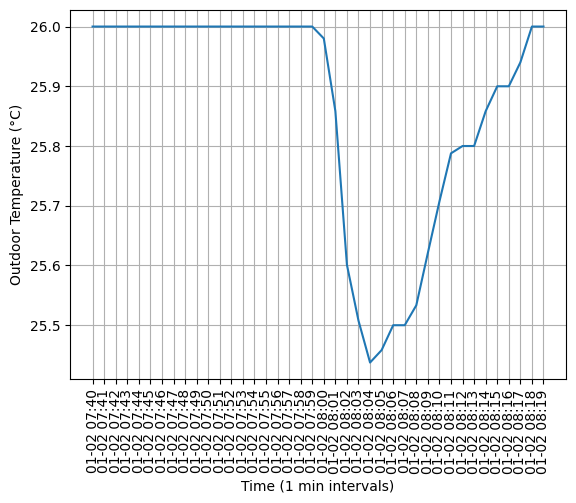

In [93]:
t1= 1900
dt= 40

plt.plot(df_temp_final['time'].iloc[t1:t1+dt] , df_temp_final['temperature'].iloc[t1:t1+dt])
plt.xticks(rotation=90)
plt.grid()
plt.xlabel('Time (1 min intervals)')
plt.ylabel('Outdoor Temperature (°C)')
plt.show()

### Irradiance

In [51]:
df_irr = pd.read_csv('irradiance.csv')
df_irr.head()

,timeStamp,ghi,dni,dhi
0,2014-01-02 08:00:00,0.0,0.0,0.0
1,2014-01-02 08:01:00,0.0,0.0,0.0
2,2014-01-02 08:02:00,0.0,0.0,0.0
3,2014-01-02 08:03:00,0.0,0.0,0.0
4,2014-01-02 08:04:00,0.0,0.0,0.0


In [68]:
df_irr_final= (df_irr
               .pipe(take_only_ghi)
               .pipe(average_over_years))
df_irr_final

,time,irradiance
0,01-02 08:01,0.0
1,01-02 08:02,0.0
2,01-02 08:03,0.0
3,01-02 08:04,0.0
4,01-02 08:05,0.0
...,...,...
527034,01-15 07:55,0.0
527035,01-15 07:56,0.0
527036,01-15 07:57,0.0
527037,01-15 07:58,0.0


In [67]:
def take_only_ghi(df):
    return df[['timeStamp', 'ghi']].rename(columns={'timeStamp': 'time', 'ghi': 'irradiance'})

def average_over_years(df):
    df['time'] = pd.to_datetime(df['time'])
    df= df.groupby('time', as_index=False).mean().copy()
    df= df.iloc[1:527040, :].reset_index(drop=True)  # remove leap year day
    df['time'] = df['time'].dt.strftime('%m-%d %H:%M')
    return df

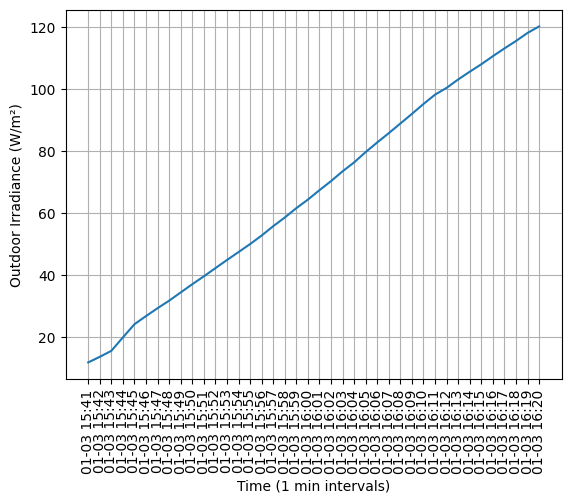

In [88]:
t1= 1900
dt= 40
plt.plot(df_irr_final['time'].iloc[t1:t1+dt] , df_irr_final['irradiance'].iloc[t1:t1+dt])
plt.xticks(rotation=90)
plt.grid()
plt.xlabel('Time (1 min intervals)')
plt.ylabel('Outdoor Irradiance (W/m²)')
plt.show()

! occhio shift ora 